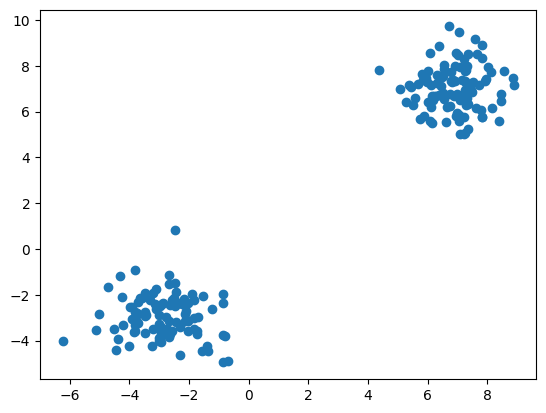

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# 真實數據
np.random.seed(42)
data1 = np.random.randn(100, 2) + np.array([7, 7])
data2 = np.random.randn(100, 2) + np.array([-3, -3])
real_data = np.vstack([data1, data2])

# 繪制真實數據
plt.scatter(real_data[:, 0], real_data[:, 1])
plt.show()

## GAN 實作

In [77]:
# 定義生成器跟鑑別器
# 生成器
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(128, momentum=0.8),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256, momentum=0.8),
            nn.Linear(256, output_dim)
        )
    def forward(self, x):
        return self.model(x)

# 鑑別器
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

In [78]:
# 訓練模型
# 設置參數
input_size = 2
output_size = 2
num_epochs = 20000
batch_size = 64
lr = 0.002

# 初始化
generator = Generator(input_size, output_size)
discriminator = Discriminator(input_size)

# 定義損失函數
criterion = nn.BCELoss()

# 定義優化器
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# 原本的資料轉成tensor向量
real_data = torch.as_tensor(real_data, dtype=torch.float32)

# 訓練gan
for epoch in range(num_epochs):
    # 隨機抽取一個小批量的真實數據
    idx = torch.randint(0, real_data.size(0), (batch_size,))
    real_batch = real_data[idx]
    
    # 生成label
    #real_labels = torch.ones(batch_size, 1)
    real_labels = torch.full((batch_size, 1), 0.9)  # 平滑标签
    fake_labels = torch.zeros(batch_size, 1)
    
    # 訓練生成器
    g_optimizer.zero_grad()
    
    z = torch.randn(batch_size, input_size)
    fake_data = generator(z)
    fake_data_noisy = fake_data + 0.1 * torch.randn_like(fake_data)  # 加入噪声
    g_loss = criterion(discriminator(fake_data_noisy), real_labels)
    
    # 更新生成器的嵾數
    g_loss.backward()
    g_optimizer.step()
    
    # 訓練鑑別器
    d_optimizer.zero_grad()
    
    # 真實資料的損失
    d_loss_real = criterion(discriminator(real_batch), real_labels)
    
    # 計算鑑別器對假資料的loss
    d_loss_fake = criterion(discriminator(fake_data_noisy.detach()), fake_labels)
    
    # 鑑別器總loss
    d_loss = (d_loss_real + d_loss_fake) / 2
    
    # 更新鑑別器的嵾數
    d_loss.backward()
    d_optimizer.step()
    
    # 每1000次打印訓練數據
    if (epoch+1) % 1000 == 0:
        print('Epoch [{}/{}], g_loss: {:.4f}, d_loss: {:.4f}'.format(epoch+1, num_epochs, g_loss.item(), d_loss.item()))

Epoch [1000/20000], g_loss: 0.8622, d_loss: 0.6643
Epoch [2000/20000], g_loss: 0.7783, d_loss: 0.6942
Epoch [3000/20000], g_loss: 0.7753, d_loss: 0.7215
Epoch [4000/20000], g_loss: 0.8512, d_loss: 0.6840
Epoch [5000/20000], g_loss: 0.9193, d_loss: 0.6499
Epoch [6000/20000], g_loss: 0.8672, d_loss: 0.6593
Epoch [7000/20000], g_loss: 0.8116, d_loss: 0.6741
Epoch [8000/20000], g_loss: 0.8503, d_loss: 0.6800
Epoch [9000/20000], g_loss: 0.7902, d_loss: 0.6729
Epoch [10000/20000], g_loss: 0.8652, d_loss: 0.6994
Epoch [11000/20000], g_loss: 0.7552, d_loss: 0.6780
Epoch [12000/20000], g_loss: 0.8190, d_loss: 0.6706
Epoch [13000/20000], g_loss: 0.8163, d_loss: 0.6868
Epoch [14000/20000], g_loss: 0.8816, d_loss: 0.6676
Epoch [15000/20000], g_loss: 0.8720, d_loss: 0.6760
Epoch [16000/20000], g_loss: 0.8882, d_loss: 0.6436
Epoch [17000/20000], g_loss: 0.9460, d_loss: 0.6837
Epoch [18000/20000], g_loss: 0.8166, d_loss: 0.7019
Epoch [19000/20000], g_loss: 1.4132, d_loss: 0.5777
Epoch [20000/20000], 

Generated Data:


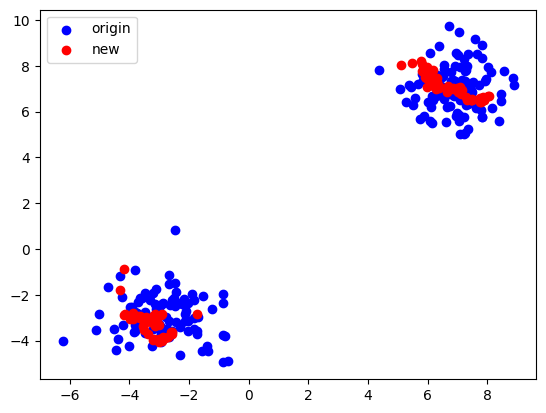

In [98]:
# 生成新資料
z = torch.randn(100, input_size)
generated_data = generator(z).detach().numpy()

# 印出生成資料
print("Generated Data:")
# print(generated_data)

# 繪製真實資料跟生成資料的分布圖
plt.scatter(real_data[:, 0], real_data[:, 1], label='origin', color='blue')
plt.scatter(generated_data[:, 0], generated_data[:, 1], label='new', color='red')
plt.legend()
plt.show()